In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set plot style and size
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [61]:
df = pd.read_csv('airline_passenger_timeseries.csv')
df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


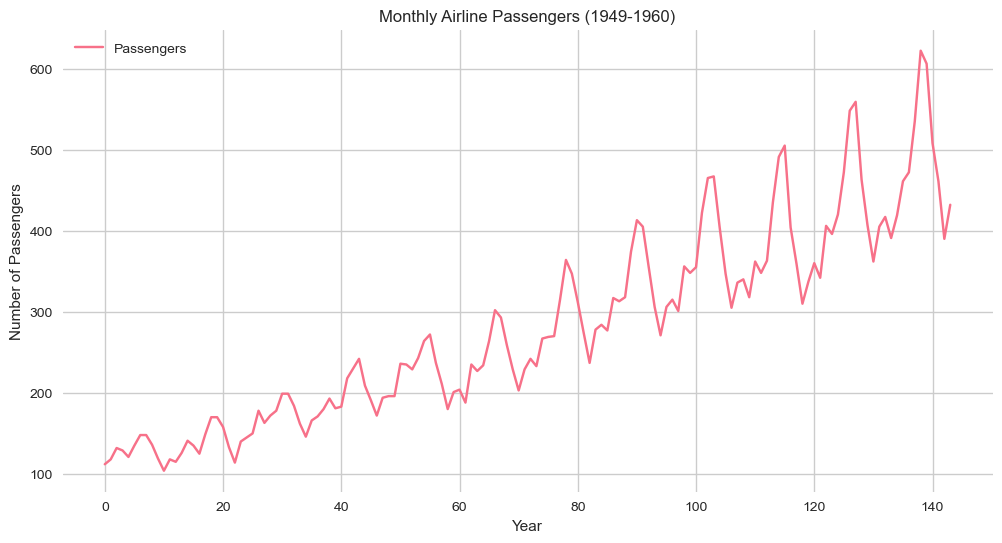

In [62]:
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

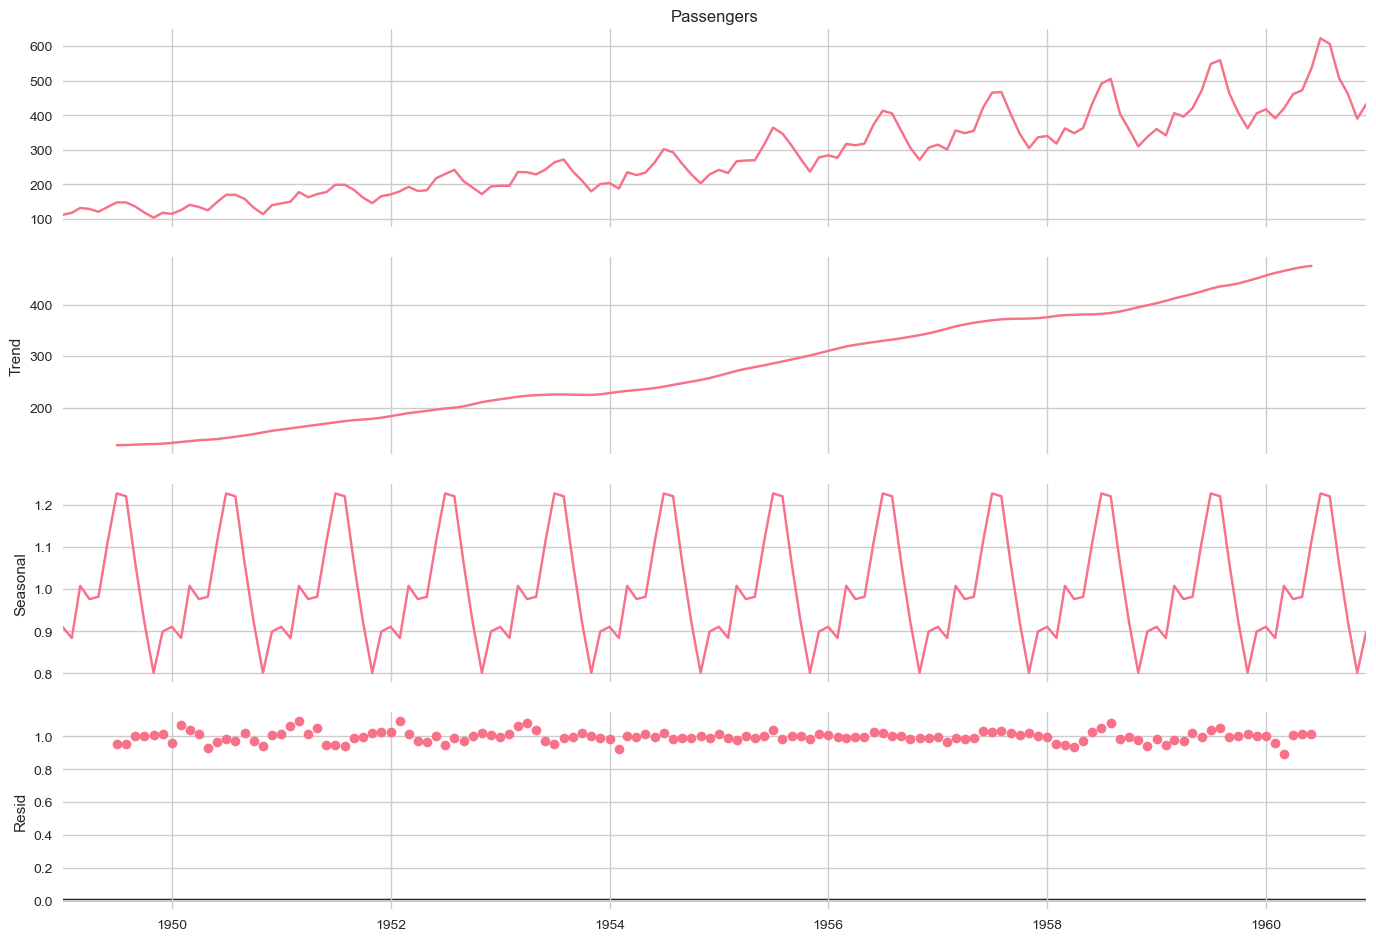

In [63]:
# Convert 'Month' to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Decompose the time series to visualize its components
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

In [64]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


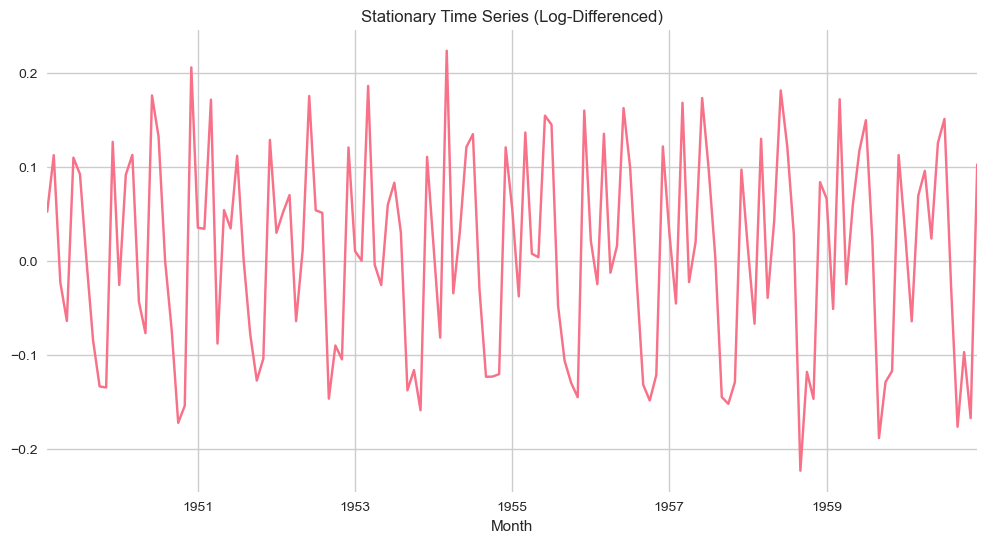

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [65]:
df_log = np.log(df['Passengers'])
df_diff = df_log.diff().dropna()
df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()
test_stationarity(df_diff)

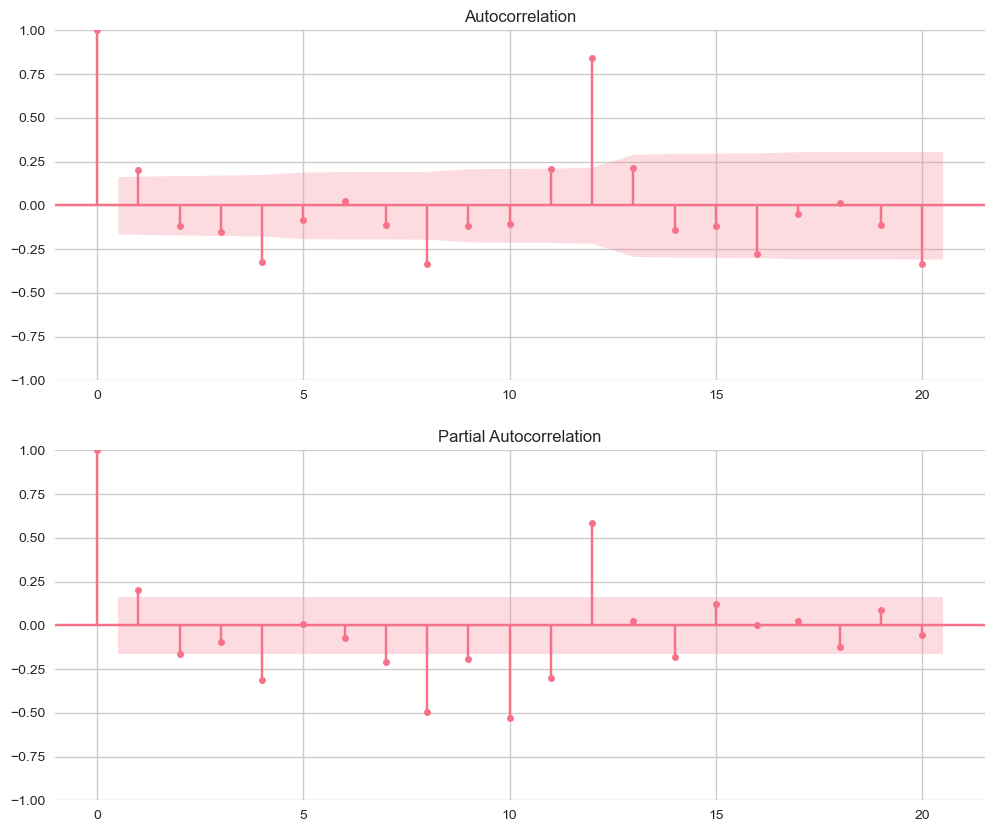

In [66]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff, ax=ax1, lags=20)
plot_pacf(df_diff, ax=ax2, lags=20)
plt.show()

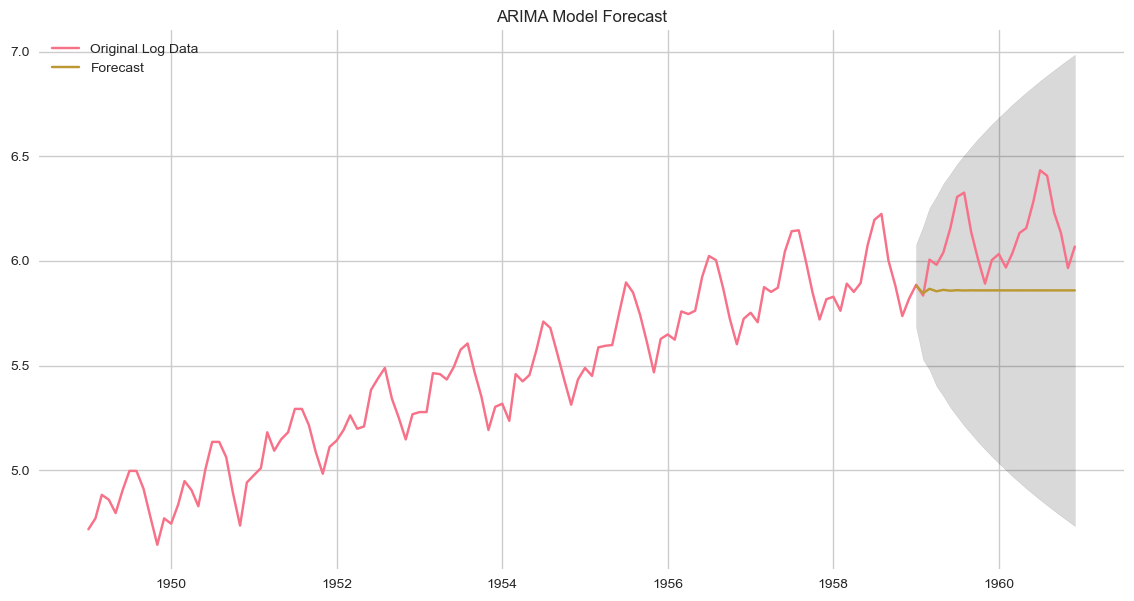

In [67]:
train_data = df_log[:'1958']
test_data = df_log['1959':]
model = ARIMA(train_data, order=(1, 1, 1), freq='MS')
arima_result = model.fit()
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

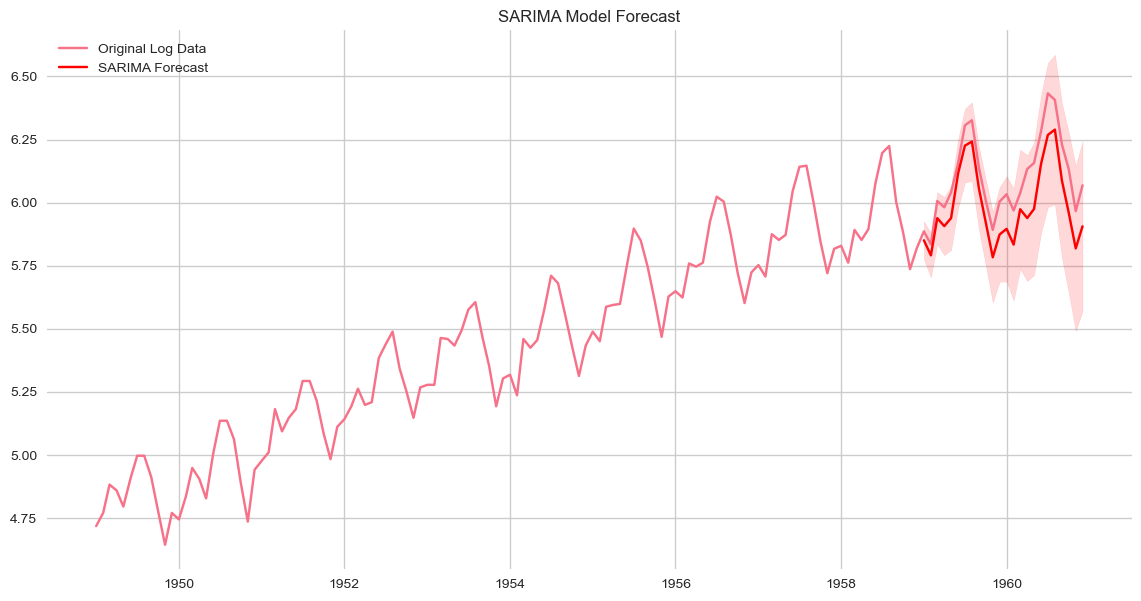

In [68]:
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

SARIMA Model RMSE: 53.02


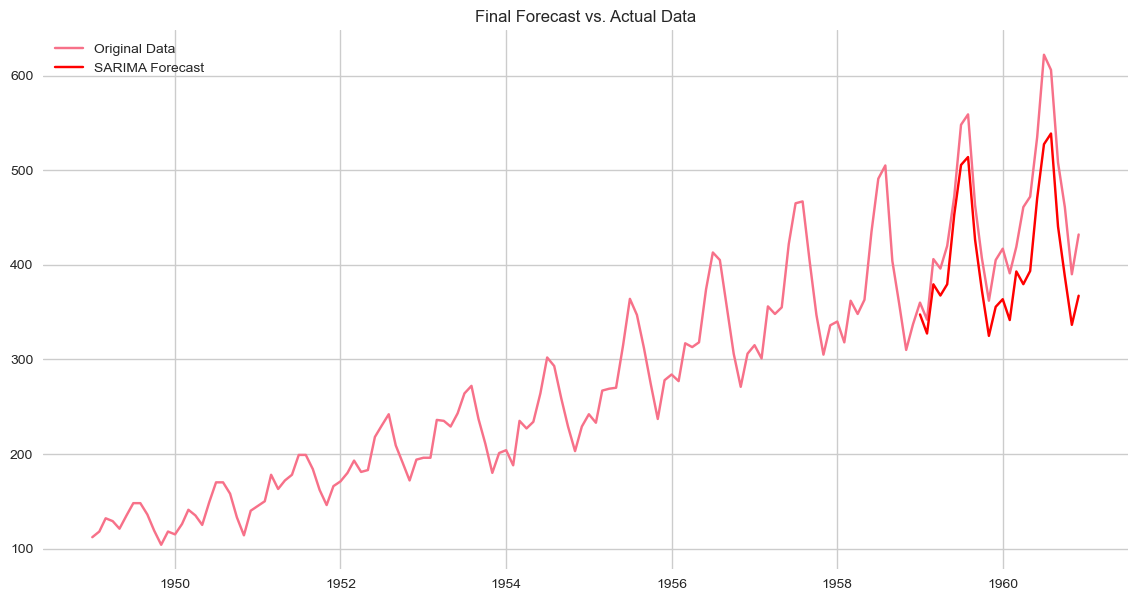

In [69]:
original_test_data = np.exp(test_data)
sarima_predictions = np.exp(sarima_forecast.predicted_mean)
rmse = np.sqrt(mean_squared_error(original_test_data, sarima_predictions))
print(f"SARIMA Model RMSE: {rmse:.2f}")
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')
plt.title('Final Forecast vs. Actual Data')
plt.legend()
plt.show()

MY OWN ANALYSIS 

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [71]:

def adf_test(series, title):
    """Perform Augmented Dickey-Fuller test for stationarity"""
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'\n{title}:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("Series is stationary (reject null hypothesis)")
    else:
        print("Series is not stationary (fail to reject null hypothesis)")
    
    return result[1] <= 0.05

def evaluate_model(model_fit, test_data):
    """Calculate model performance metrics"""
    forecast = model_fit.forecast(steps=len(test_data))
    mae = np.mean(np.abs(test_data - forecast))
    rmse = np.sqrt(np.mean((test_data - forecast)**2))
    mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'AIC': model_fit.aic,
        'BIC': model_fit.bic
    }

Loading and preprocessing data...
Dataset shape: (144, 1)
Date range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00
Basic statistics:
       Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000

Performing exploratory data analysis...


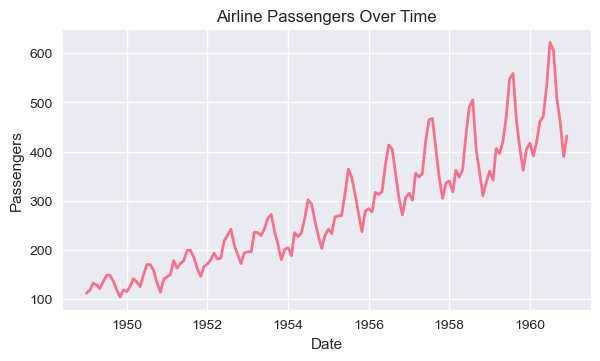

In [72]:
# ===============================
# 1. DATA LOADING AND PREPROCESSING
# ===============================
print("Loading and preprocessing data...")
df = pd.read_csv('airline_passenger_timeseries.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"Basic statistics:\n{df.describe()}")

# ===============================
# 2. EXPLORATORY DATA ANALYSIS
# ===============================
print("\nPerforming exploratory data analysis...")

# Original time series plot
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.plot(df['Passengers'], linewidth=2)
plt.title('Airline Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)

Performing seasonal decomposition...


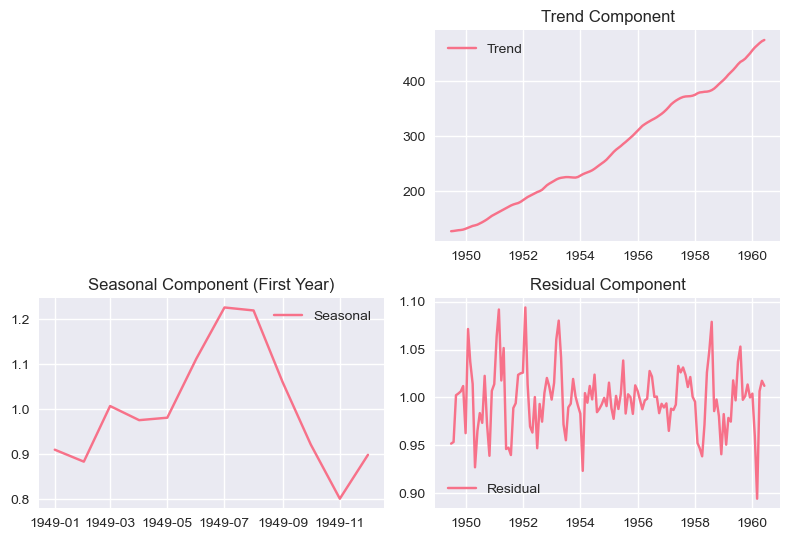

In [73]:
# ===============================
# 3. SEASONAL DECOMPOSITION
# ===============================
print("Performing seasonal decomposition...")
decomposition = seasonal_decompose(df['Passengers'], model='multiplicative', period=12)

plt.subplot(2, 2, 2)
plt.plot(decomposition.trend.dropna(), label='Trend')
plt.title('Trend Component')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(decomposition.seasonal[:12], label='Seasonal')
plt.title('Seasonal Component (First Year)')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(decomposition.resid.dropna(), label='Residual')
plt.title('Residual Component')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [74]:
# ===============================
# 4. STATIONARITY TESTING
# ===============================
print("Testing for stationarity...")

# Test original series
is_stationary_original = adf_test(df['Passengers'], 'Original Series')

# Apply differencing
df['First_Diff'] = df['Passengers'].diff()
df['Seasonal_Diff'] = df['Passengers'].diff(12)
df['Both_Diff'] = df['Passengers'].diff(12).diff()

# Test differenced series
is_stationary_diff = adf_test(df['First_Diff'], 'First Differenced Series')
is_stationary_seasonal = adf_test(df['Seasonal_Diff'], 'Seasonal Differenced Series')
is_stationary_both = adf_test(df['Both_Diff'], 'Seasonal + First Differenced Series')

Testing for stationarity...

Original Series:
ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Series is not stationary (fail to reject null hypothesis)

First Differenced Series:
ADF Statistic: -2.829267
p-value: 0.054213
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Series is not stationary (fail to reject null hypothesis)

Seasonal Differenced Series:
ADF Statistic: -3.383021
p-value: 0.011551
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Series is stationary (reject null hypothesis)

Seasonal + First Differenced Series:
ADF Statistic: -15.595618
p-value: 0.000000
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Series is stationary (reject null hypothesis)



Analyzing ACF and PACF...


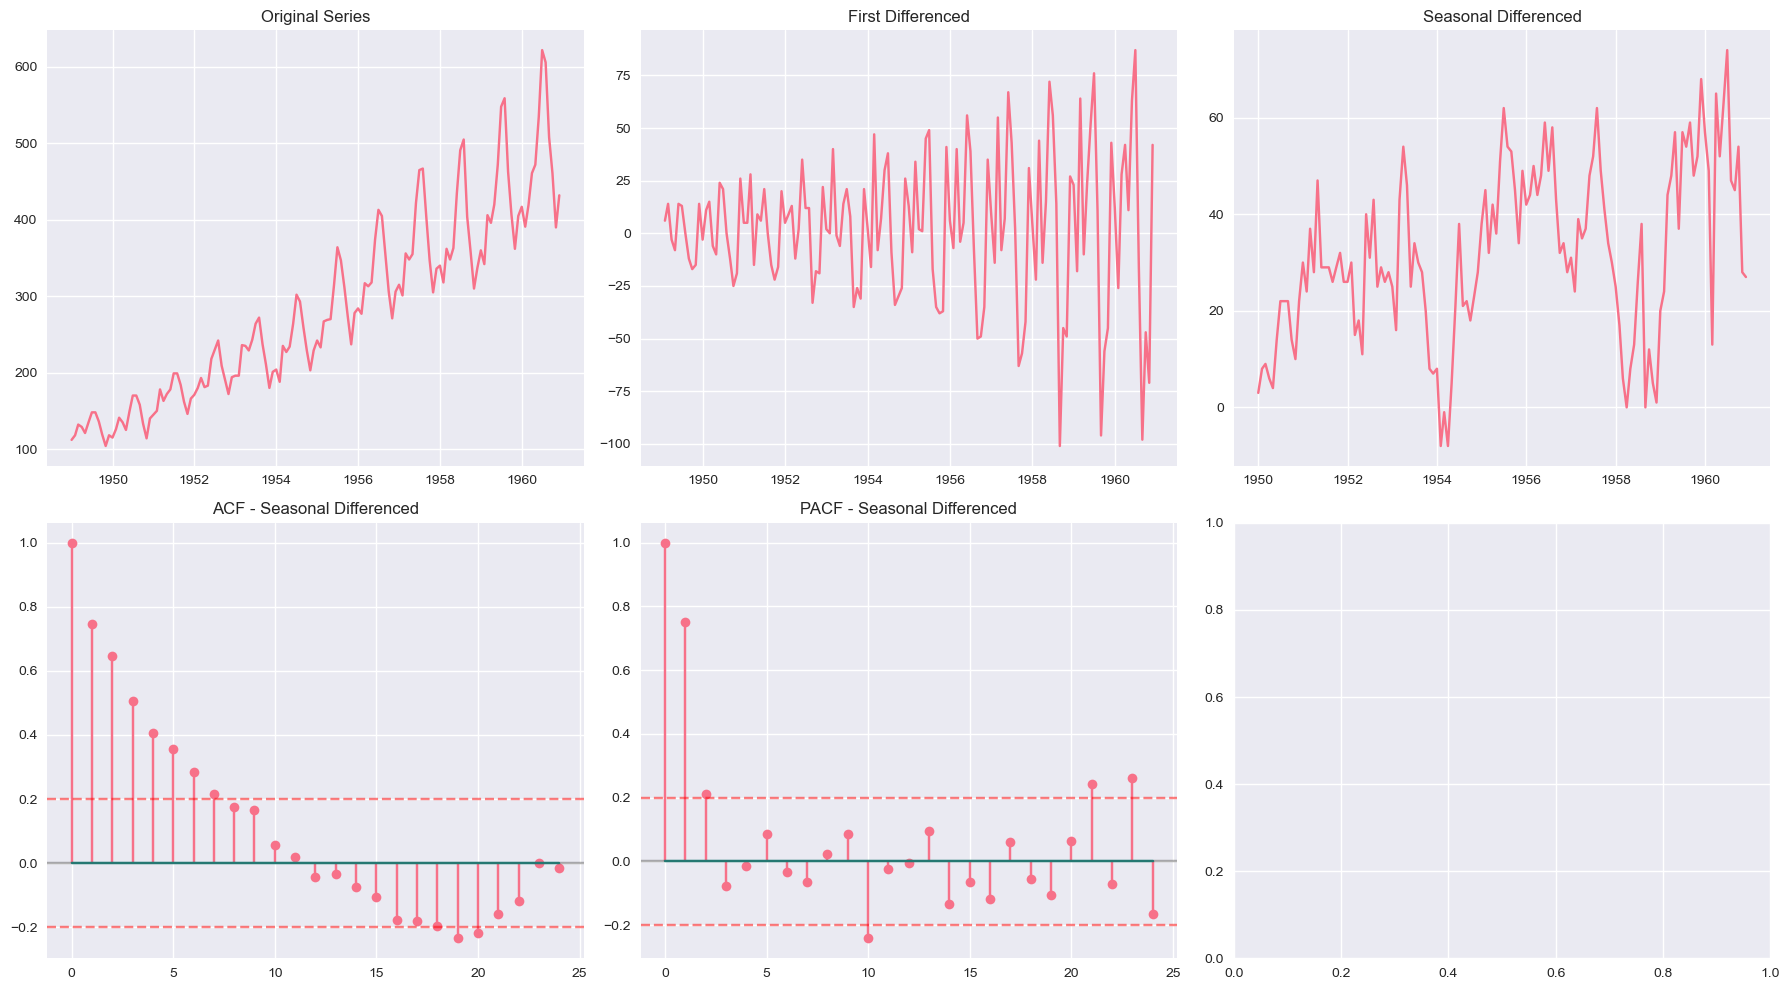

In [75]:
# ===============================
# 5. ACF AND PACF ANALYSIS
# ===============================
print("\nAnalyzing ACF and PACF...")

# Plot differenced series and ACF/PACF
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Original series
axes[0, 0].plot(df['Passengers'])
axes[0, 0].set_title('Original Series')
axes[0, 0].grid(True)

# First differenced
axes[0, 1].plot(df['First_Diff'].dropna())
axes[0, 1].set_title('First Differenced')
axes[0, 1].grid(True)

# Seasonal differenced
axes[0, 2].plot(df['Seasonal_Diff'].dropna())
axes[0, 2].set_title('Seasonal Differenced')
axes[0, 2].grid(True)

# ACF and PACF for seasonal differenced series
lags = 24
acf_vals = acf(df['Seasonal_Diff'].dropna(), nlags=lags, fft=True)
pacf_vals = pacf(df['Seasonal_Diff'].dropna(), nlags=lags)

axes[1, 0].stem(range(len(acf_vals)), acf_vals)
axes[1, 0].set_title('ACF - Seasonal Differenced')
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].axhline(y=0.2, color='red', linestyle='--', alpha=0.5)
axes[1, 0].axhline(y=-0.2, color='red', linestyle='--', alpha=0.5)

axes[1, 1].stem(range(len(pacf_vals)), pacf_vals)
axes[1, 1].set_title('PACF - Seasonal Differenced')
axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].axhline(y=0.2, color='red', linestyle='--', alpha=0.5)
axes[1, 1].axhline(y=-0.2, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [76]:
# ===============================
# 6. MODEL FITTING AND COMPARISON
# ===============================
print("\nFitting ARIMA and SARIMA models...")

# Split data
train_size = int(0.8 * len(df))
train_data = df['Passengers'][:train_size]
test_data = df['Passengers'][train_size:]

print(f"Training data: {len(train_data)} observations")
print(f"Test data: {len(test_data)} observations")

# Model specifications to test
model_results = []

# ARIMA models
arima_orders = [(0,1,1), (0,1,2), (1,1,0), (1,1,1), (2,1,0)]

for order in arima_orders:
    try:
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()
        metrics = evaluate_model(model_fit, test_data)
        
        result = {
            'Model': f'ARIMA{order}',
            'Order': order,
            'Seasonal_Order': None,
            **metrics
        }
        model_results.append(result)
        print(f"✓ ARIMA{order} fitted successfully")
        
    except Exception as e:
        print(f"✗ ARIMA{order} failed: {str(e)}")

# SARIMA models
sarima_orders = [
    ((0,1,1), (0,1,1,12)),
    ((0,1,1), (1,1,0,12)),
    ((1,1,0), (0,1,1,12)),
    ((1,1,1), (0,1,1,12)),
    ((2,1,1), (0,1,1,12)),
    ((1,1,1), (1,1,1,12))
]

for order, seasonal_order in sarima_orders:
    try:
        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        metrics = evaluate_model(model_fit, test_data)
        
        result = {
            'Model': f'SARIMA{order}x{seasonal_order}',
            'Order': order,
            'Seasonal_Order': seasonal_order,
            **metrics
        }
        model_results.append(result)
        print(f"✓ SARIMA{order}x{seasonal_order} fitted successfully")
        
    except Exception as e:
        print(f"✗ SARIMA{order}x{seasonal_order} failed")


Fitting ARIMA and SARIMA models...
Training data: 115 observations
Test data: 29 observations
✓ ARIMA(0, 1, 1) fitted successfully
✓ ARIMA(0, 1, 2) fitted successfully
✓ ARIMA(1, 1, 0) fitted successfully
✓ ARIMA(1, 1, 1) fitted successfully
✓ ARIMA(2, 1, 0) fitted successfully
✓ SARIMA(0, 1, 1)x(0, 1, 1, 12) fitted successfully
✓ SARIMA(0, 1, 1)x(1, 1, 0, 12) fitted successfully
✓ SARIMA(1, 1, 0)x(0, 1, 1, 12) fitted successfully
✓ SARIMA(1, 1, 1)x(0, 1, 1, 12) fitted successfully
✓ SARIMA(2, 1, 1)x(0, 1, 1, 12) fitted successfully
✓ SARIMA(1, 1, 1)x(1, 1, 1, 12) fitted successfully


In [77]:
# ===============================
# 7. MODEL COMPARISON AND SELECTION
# ===============================
print("\nComparing model performance...")

# Convert to DataFrame
results_df = pd.DataFrame(model_results)

# Display top 5 models by AIC
print("\nTOP 5 MODELS BY AIC:")
print("="*60)
top_models_aic = results_df.nsmallest(5, 'AIC')
for _, row in top_models_aic.iterrows():
    print(f"{row['Model']:25} | AIC: {row['AIC']:7.2f} | RMSE: {row['RMSE']:6.2f} | MAPE: {row['MAPE']:5.2f}%")

# Select best model
best_model = results_df.loc[results_df['AIC'].idxmin()]
print(f"\nBEST MODEL: {best_model['Model']}")
print(f"AIC: {best_model['AIC']:.2f}, RMSE: {best_model['RMSE']:.2f}, MAPE: {best_model['MAPE']:.2f}%")


Comparing model performance...

TOP 5 MODELS BY AIC:
SARIMA(1, 1, 0)x(0, 1, 1, 12) | AIC:  755.98 | RMSE:  30.44 | MAPE:  5.12%
SARIMA(0, 1, 1)x(1, 1, 0, 12) | AIC:  756.17 | RMSE:  30.47 | MAPE:  5.13%
SARIMA(0, 1, 1)x(0, 1, 1, 12) | AIC:  756.38 | RMSE:  30.60 | MAPE:  5.16%
SARIMA(1, 1, 1)x(0, 1, 1, 12) | AIC:  756.63 | RMSE:  29.85 | MAPE:  5.00%
SARIMA(1, 1, 1)x(1, 1, 1, 12) | AIC:  758.26 | RMSE:  30.14 | MAPE:  5.05%

BEST MODEL: SARIMA(1, 1, 0)x(0, 1, 1, 12)
AIC: 755.98, RMSE: 30.44, MAPE: 5.12%



Fitting final model and generating forecasts...
                                      SARIMAX Results                                       
Dep. Variable:                           Passengers   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -374.991
Date:                              Sun, 14 Sep 2025   AIC                            755.982
Time:                                      12:47:01   BIC                            763.856
Sample:                                  01-01-1949   HQIC                           759.170
                                       - 07-01-1958                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1778      0.092     -1.925      

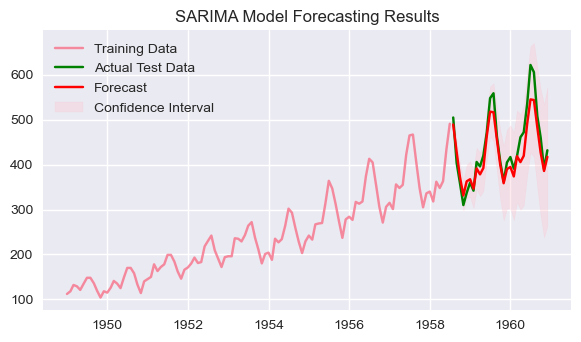

In [78]:
# ===============================
# 8. FINAL MODEL FITTING AND FORECASTING
# ===============================
print("\nFitting final model and generating forecasts...")

# Fit best model
best_order = (1, 1, 0)
best_seasonal_order = (0, 1, 1, 12)
final_model = SARIMAX(train_data, order=best_order, seasonal_order=best_seasonal_order)
final_model_fit = final_model.fit(disp=False)

print(final_model_fit.summary())

# Generate forecasts
forecast = final_model_fit.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot results
plt.figure(figsize=(15, 8))

# Forecast plot
plt.subplot(2, 2, 1)
plt.plot(train_data.index, train_data, label='Training Data', alpha=0.8)
plt.plot(test_data.index, test_data, label='Actual Test Data', color='green')
plt.plot(test_data.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(test_data.index, 
                conf_int.iloc[:, 0], 
                conf_int.iloc[:, 1], 
                color='pink', alpha=0.3, label='Confidence Interval')
plt.title('SARIMA Model Forecasting Results')
plt.legend()
plt.grid(True)


Performing residual analysis...


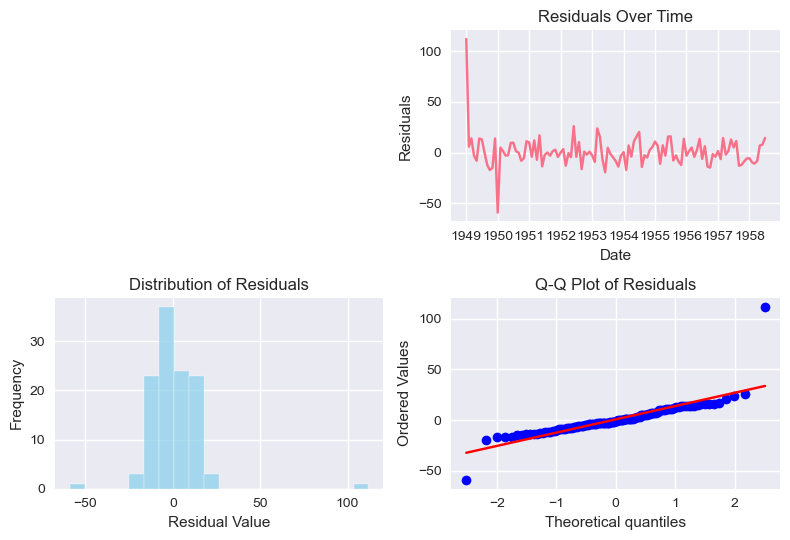


Residual Statistics:
Mean: 0.7934
Std: 15.2619
Skewness: 2.8785
Kurtosis: 23.9645
Jarque-Bera Test: Statistic=2910.6540, p-value=0.0000


In [79]:
# ===============================
# 9. RESIDUAL ANALYSIS
# ===============================
print("\nPerforming residual analysis...")

residuals = final_model_fit.resid

# Residual plots
plt.subplot(2, 2, 2)
plt.plot(residuals)
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.hist(residuals, bins=20, alpha=0.7, color='skyblue')
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)

# Q-Q plot
plt.subplot(2, 2, 4)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.grid(True)

plt.tight_layout()
plt.show()

# Residual statistics
print(f"\nResidual Statistics:")
print(f"Mean: {np.mean(residuals):.4f}")
print(f"Std: {np.std(residuals):.4f}")
print(f"Skewness: {stats.skew(residuals):.4f}")
print(f"Kurtosis: {stats.kurtosis(residuals):.4f}")

# Normality test
jb_stat, jb_p_value = stats.jarque_bera(residuals)
print(f"Jarque-Bera Test: Statistic={jb_stat:.4f}, p-value={jb_p_value:.4f}")


Generating future forecasts...


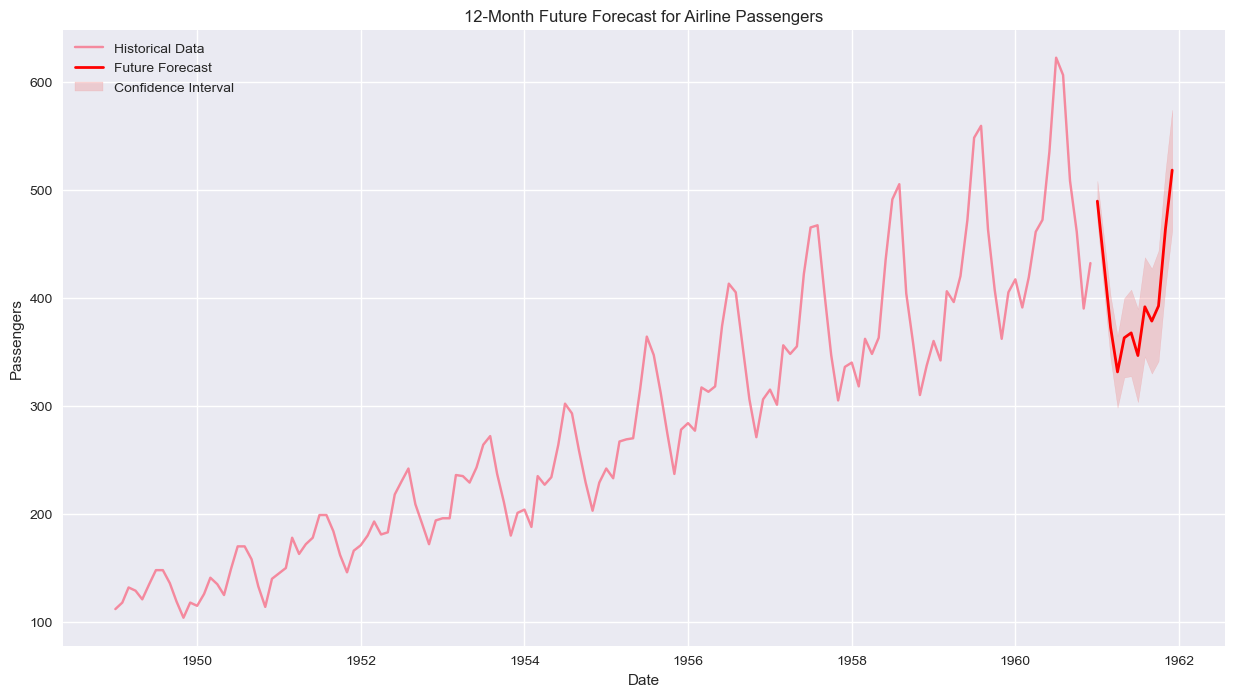


FUTURE FORECASTS (Next 12 months):
1961-01: 489 passengers (CI: 471-508)
1961-02: 429 passengers (CI: 404-453)
1961-03: 373 passengers (CI: 344-402)
1961-04: 331 passengers (CI: 298-364)
1961-05: 363 passengers (CI: 326-400)
1961-06: 367 passengers (CI: 327-407)
1961-07: 347 passengers (CI: 303-390)
1961-08: 392 passengers (CI: 346-437)
1961-09: 378 passengers (CI: 330-427)
1961-10: 392 passengers (CI: 341-443)
1961-11: 464 passengers (CI: 410-517)
1961-12: 518 passengers (CI: 462-574)


In [80]:
# ===============================
# 10. FUTURE FORECASTING
# ===============================
print("\nGenerating future forecasts...")

# Generate 12-month future forecast
future_steps = 12
future_forecast = final_model_fit.get_forecast(steps=future_steps)
future_mean = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()

# Create future dates
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), 
                           periods=future_steps, freq='MS')

# Plot future forecasts
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['Passengers'], label='Historical Data', alpha=0.8)
plt.plot(future_dates, future_mean, label='Future Forecast', 
         color='red', linewidth=2)
plt.fill_between(future_dates, 
                future_ci.iloc[:, 0], 
                future_ci.iloc[:, 1], 
                color='lightcoral', alpha=0.3, label='Confidence Interval')
plt.title('12-Month Future Forecast for Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()

# Display future forecasts
print("\nFUTURE FORECASTS (Next 12 months):")
print("="*50)
for i in range(future_steps):
    date = future_dates[i]
    forecast_val = future_mean.iloc[i]
    lower_ci = future_ci.iloc[i, 0]
    upper_ci = future_ci.iloc[i, 1]
    print(f"{date.strftime('%Y-%m')}: {forecast_val:.0f} passengers (CI: {lower_ci:.0f}-{upper_ci:.0f})")


In [81]:
def test_stationarity(timeseries, title="Time Series"): 
    print(f'\nResults of Dickey-Fuller Test for {title}:')
    print('=' * 60)
    
    # Perform Dickey-Fuller test
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    
    # Create output series with test results
    dfoutput = pd.Series(dftest[0:4], 
                        index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    # Add critical values
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    
    print(dfoutput)
    
    # Interpretation
    print('\nInterpretation:')
    if dftest[1] <= 0.05:
        print("✓ Series is STATIONARY (reject null hypothesis)")
        print(f"  p-value ({dftest[1]:.6f}) <= 0.05")
        is_stationary = True
    else:
        print("✗ Series is NON-STATIONARY (fail to reject null hypothesis)")
        print(f"  p-value ({dftest[1]:.6f}) > 0.05")
        is_stationary = False
    
    return is_stationary

In [82]:
# Test original series
test_stationarity(df['Passengers'], "Original Airline Passenger Series")


Results of Dickey-Fuller Test for Original Airline Passenger Series:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

Interpretation:
✗ Series is NON-STATIONARY (fail to reject null hypothesis)
  p-value (0.991880) > 0.05


False

In [83]:
# Test differenced series
df['First_Diff'] = df['Passengers'].diff()
test_stationarity(df['First_Diff'], "First Differenced Series")

df['Seasonal_Diff'] = df['Passengers'].diff(12)
test_stationarity(df['Seasonal_Diff'], "Seasonal Differenced Series")

df['Both_Diff'] = df['Passengers'].diff(12).diff()
test_stationarity(df['Both_Diff'], "Seasonal + First Differenced Series")


Results of Dickey-Fuller Test for First Differenced Series:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

Interpretation:
✗ Series is NON-STATIONARY (fail to reject null hypothesis)
  p-value (0.054213) > 0.05

Results of Dickey-Fuller Test for Seasonal Differenced Series:
Test Statistic                  -3.383021
p-value                          0.011551
#Lags Used                       1.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

Interpretation:
✓ Series is STATIONARY (reject null hypothesis)
  p-value (0.011551) <= 0.05

Results of Dickey-Fuller Test for Seasonal + First Differ

True